# Использование ежедневных обменных курсов валют для предсказания ВВП и ИПЦ

In this notebook, we use monthly industrial producation % yoy growth (IP_YOY) and monthly leading indicator %yoy growth (LEI_YOY) to predict quarterly gdp % yoy growth (GDP_CYOY).

The midaspy package is modified to allow for two high frequency indicators. Specifically, the following functions are added: mix_freq2, ssr2, jacobian2, estimate2, forecast2, midas_adl2, fixed_window2, rolling2, recursive2. The new functions can be used for both MIDAS and autoregressive MIDAS by changing the value of ylag. For the polynomial b in MIDAS, we can use exponential Almon weights (‘expalmon’) or beta weights (‘beta’). For the model training window size, we can use fixed window (‘fixed’), rolling basis (‘rolling’) or recursive (‘recursive’). In addition, the original estimate and forecast functions are modified to allow for different number of low frequency data lags.

We can change the parameters and training window to evaluate the forecast accuracy of MIDAS. As a measure of accuracy, the relative MSE will be used in our application, which is defined as MSE of MIDAS divided by the MSE of the benchmark forecast. The benchmark forecast is the in-sample mean of GDP growth recomputed every recursion.

In [3]:
%matplotlib inline
import datetime
import numpy as np
import pandas as pd

from midas.mix import mix_freq, mix_freq2
from midas.adl import estimate, forecast, midas_adl, rmse, estimate2,forecast2, midas_adl2

In [5]:
# Read data
gdp_cpi = pd.read_csv('gdp_cpi_mm.csv', parse_dates=['DATE'], dayfirst=True, index_col='DATE', sep=';')
gdp_cpi = gdp_cpi.rename(columns={'GDP' : 'gdp', 'CPI' : 'cpi'})
gdp = gdp_cpi[['gdp']]
gdp = (gdp - gdp.mean()) / gdp.std() # Нормализация данных
gdp

,gdp
DATE,
2003-01-01,-2.326341
2003-02-01,-2.276421
2003-03-01,-1.866560
2003-04-01,-1.962366
2003-05-01,-2.102615
...,...
2023-02-01,-0.194481
2023-03-01,1.078712
2023-04-01,0.747866


In [5]:
cpi = gdp_cpi[['CPI']]
cpi

,CPI
DATE,
2003-01-01,104.27
2003-02-01,101.85
2003-03-01,101.82
2003-04-01,102.01
2003-05-01,102.03
...,...
2023-02-01,101.26
2023-03-01,100.55
2023-04-01,100.35


In [3]:
ex_rates = pd.read_csv('ex_rates.csv', parse_dates=['DATE'], dayfirst=True, index_col='DATE', sep=';')
ex_rates['usd_byn'] = ex_rates['usd_byn'].str.replace(" ", "").astype(float)
ex_rates['eur_byn'] = ex_rates['eur_byn'].str.replace(" ", "").astype(float)
ex_rates

,usd_byn,eur_byn,rur_byn
DATE,,,
2005-01-01,2170.0000,2955.6500,77.9100
2005-01-02,2170.0000,2955.6500,77.9100
2005-01-03,2170.0000,2955.6500,77.9100
2005-01-04,2170.0000,2938.4000,77.9100
2005-01-05,2170.0000,2909.4300,77.9100
...,...,...,...
2023-07-19,3.0207,3.3980,3.3344
2023-07-20,3.0336,3.4061,3.3261
2023-07-21,3.0282,3.3954,3.3266


In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
norm_df = pd.DataFrame(ex_rates['2016-07-01':])
norm_df['usd_byn'] = scaler.fit_transform(ex_rates[['usd_byn']]['2016-07-01':])
norm_df['eur_byn'] = scaler.fit_transform(ex_rates[['eur_byn']]['2016-07-01':])
norm_df['rur_byn'] = scaler.fit_transform(ex_rates[['rur_byn']]['2016-07-01':])

<Axes: xlabel='DATE'>

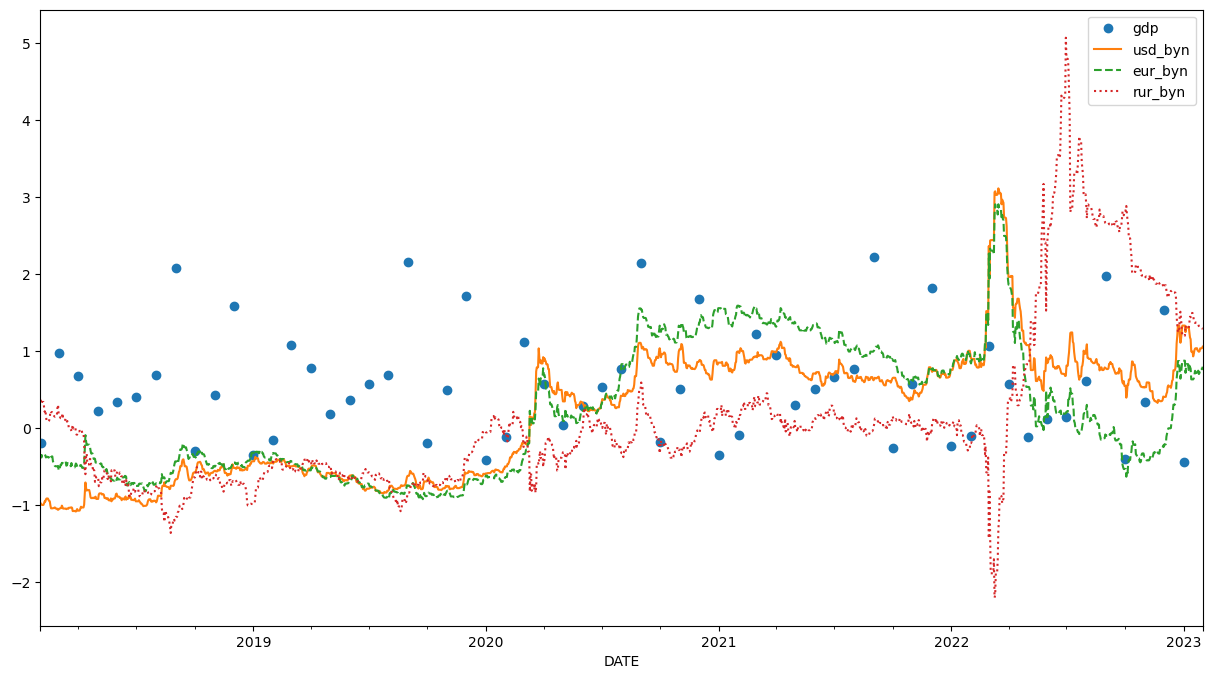

In [18]:
# Plot the sample data
df = pd.concat([gdp, cpi, norm_df], axis=1)
df.columns = ['gdp','cpi','usd_byn', 'eur_byn', 'rur_byn']
df[['gdp','usd_byn', 'eur_byn', 'rur_byn']].loc['2018-01-31':'2023-01-31'].plot(figsize=(15,8), style=['o','-', '--', ':'])

<Axes: xlabel='DATE'>

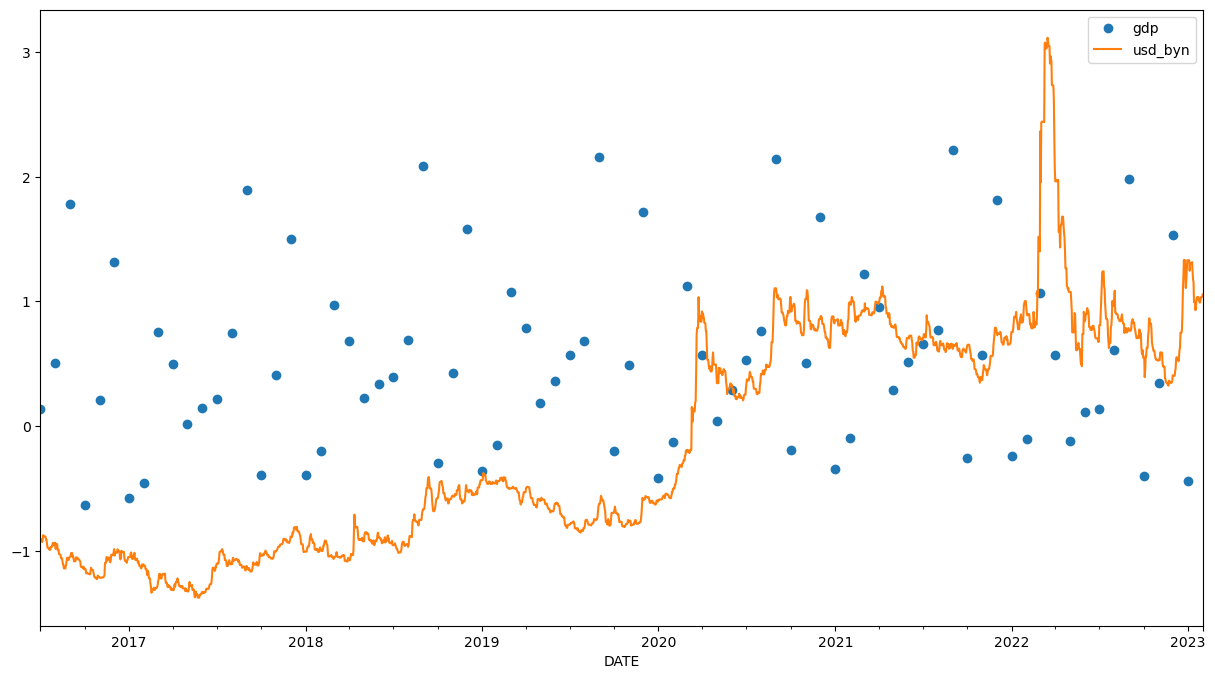

In [21]:
# Plot the sample data
df[['gdp','usd_byn']].loc['2016-07-01':'2023-01-31'].plot(figsize=(15,8), style=['o','-', '--', ':'])

## Mixing Frequencies

Первый шаг заключается в смешении частот (frequency mixing). В данном случае мы смешиваем ежедневные данные (курс доллара и евро) с месячными данными (показатель ВВП).

In [29]:
y, yl, x1, x2, yf, ylf, x1f, x2f =mix_freq2(gdp.GDP, ex_rates.eur_byn, ex_rates.usd_byn, "3m","3m", 1, 2,
                                 start_date=datetime.datetime(2016,7,1),
                                 end_date=datetime.datetime(2018,7,1))

## Fitting the Model

Because of the form of the MIDAS model, fitting the model requires using non-linear least squares.  For now, if you call the __estimate2__ function directly, you'll get back a results of type scipy.optimize.optimize.OptimizeResult. We use data from 2011-3-31 to 2013-3-31 to fit the model and use the rest of data to forecast.

In [30]:
res = estimate2(y, yl, x1, x2, poly1='expalmon', poly2='expalmon')
res.x
#opt params [beta0, beta1, beta2, theta11, theta12, theta21, theta22, lambda]

array([ 0.438781  ,  1.21333647, -1.34236712, -2.52960399, -4.6046142 ,
       -2.38445694, -4.43896028, -0.27096278])

You can also call __forecast2__ directly.  This will use the optimization results returned from __eatimate2__ to produce a forecast for every date in the index of the forecast inputs (here x1f, x2f and ylf):

In [31]:
fc = forecast2(x1f, x2f, ylf, res, poly1='expalmon',poly2='expalmon')
forecast_df = fc.join(yf)
forecast_df['gap'] = forecast_df.yfh - forecast_df.GDP
forecast_df

,yfh,GDP,gap
DATE,,,
2018-08-01,0.471475,0.690531,-0.219057
2018-09-01,0.405155,2.085380,-1.680225
2018-10-01,0.015671,-0.293014,0.308685
2018-11-01,0.602618,0.428672,0.173946
2018-12-01,0.379981,1.581561,-1.201581
2019-01-01,0.112059,-0.355532,0.467591
2019-02-01,0.632878,-0.153374,0.786252
2019-03-01,0.555924,1.077021,-0.521097
2019-04-01,0.188259,0.785864,-0.597604


## The midas_adl and midas_adl2 function

The __midas\_adl__ and __midas\_adl2__ function wraps up frequency-mixing, fitting, and forecasting into one process.  The default mode of forecasting is _rolling_.

### Use one monthly indicator

In [48]:
# use usd_byn
rmse_fc1, fc1 = midas_adl(gdp.GDP, ex_rates.usd_byn, 
                         start_date=datetime.datetime(2016,7,1),
                         end_date=datetime.datetime(2018,7,1),
                         xlag="3m",
                         ylag=1,
                         horizon=1,
                         poly='expalmon',
                         method='rolling')
rmse_fc1

0.36889233295296914

In [50]:
# use eur_byn
rmse_fc2, fc2 = midas_adl(gdp.GDP, ex_rates.eur_byn, 
                         start_date=datetime.datetime(2016,7,1),
                         end_date=datetime.datetime(2018,7,1),
                         xlag="3m",
                         ylag=1,
                         horizon=1,
                         poly='expalmon',
                         method='rolling')
rmse_fc2

C:\Users\User\Documents\курсач\code\midas_realization\midas\weights.py:36: RuntimeWarning: invalid value encountered in divide
  beta_vals = beta_vals / sum(beta_vals)
C:\Users\User\Documents\курсач\code\midas_realization\midas\weights.py:36: RuntimeWarning: invalid value encountered in divide
  beta_vals = beta_vals / sum(beta_vals)


0.37557663409416475

### Use two monthly indicator

In [ ]:
# use IP_YOY and LEI_YOY
rmse_fc, fc = midas_adl2(gdp.GDP, ex_rates.usd_byn, ex_rates.eur_byn, 
                         start_date=datetime.datetime(2016,7,1),
                         end_date=datetime.datetime(2017,7,1),
                         x1lag="3m",
                         x2lag="3m",
                         ylag=1,
                         horizon=1,
                         poly1='expalmon',
                         poly2='expalmon',
                         method='rolling')
rmse_fc

# Forecast quarterly GDP

In [32]:
# Set start date and end date
start_date=datetime.datetime(2016,7,1)
end_date=datetime.datetime(2018,7,1)

In [33]:
df_result=pd.DataFrame(index=ex_rates.index, columns=['final_gdp_date'])
temp=df_result.iloc[2::30].reset_index()
for i in range(0,len(temp)):
    df_result['final_gdp_date'][i*30]=temp['DATE'][i].date()
df_result[['final_gdp_date','GDP']]=df_result.join(gdp)[['final_gdp_date','GDP']].fillna(method='bfill')

In [34]:
# To compute benchmark forecast
n_month=df_result.index.get_loc(end_date)-df_result.index.get_loc(start_date)
df_result['benchmark']=df_result['GDP'].rolling(window=n_month).mean()
df_result

,final_gdp_date,GDP,benchmark
DATE,,,
2005-01-01,2005-01-03,-1.937102,NaN
2005-01-02,2005-02-02,-1.850897,NaN
2005-01-03,2005-02-02,-1.850897,NaN
2005-01-04,2005-02-02,-1.850897,NaN
2005-01-05,2005-02-02,-1.850897,NaN
...,...,...,...
2023-07-19,NaN,NaN,NaN
2023-07-20,NaN,NaN,NaN
2023-07-21,NaN,NaN,NaN


Note: GDP_CYOY is actual GDP growth, and benchmark is the in-sample mean of GDP growth recomputed every recursion.

In [35]:
# Forecast_all, n is the max horizon, we will set n=3
def forecast_all(y_in, x1_in, x2_in, start_date, end_date, x1lag, x2lag, ylag,n, 
                 forecast_horizon, poly1, poly2, method='rolling'):
    forecast_result=[]
    rmse_result=[]
    for i in range(n):
        rmse,fc=midas_adl2(y_in, x1_in, x2_in, start_date=start_date, end_date=end_date,
                           x1lag=x1lag, x2lag=x2lag, ylag=ylag, horizon=i,
                           poly1=poly1, poly2=poly2, method=method)
        forecast_result.append(fc)
        rmse_result.append(rmse)
    return forecast_result, rmse_result

In [36]:
# Define a function to assist storing forecast gdp to df_result
def store_gdp(df0,df1,df2,df):
    df0=df0.reset_index()
    df0['DATE']=df0['index']
    df0=df0.drop(['index','targets'],axis=1)
    
    df1=df1.reset_index()
    df1['DATE']=df1['index']
    df1=df1.drop(['index','targets'],axis=1)
    
    df2=df2.reset_index()
    df2['DATE']=df2['index']
    df2=df2.drop(['index','targets'],axis=1)
    
    df_result=df.copy()
    df_result=df_result.reset_index()
    df_result=df_result.merge(df2,how='left',on='DATE')
    df_result=df_result.merge(df1,how='left',on='DATE')
    df_result=df_result.merge(df0,how='left',on='DATE')
    
    df_result['preds_x']=df_result['preds_x'].shift(-2)
    df_result['preds_y']=df_result['preds_y'].shift(-1)
    df_result=df_result.fillna(0)
    df_result['forecast_gdp']=df_result['preds_x']+df_result['preds_y']+df_result['preds']
    df_result=df_result.drop(['preds_x','preds_y','preds'],axis=1).set_index('DATE')
    
    return df_result

## Use MIDAS with two indicators on a rolling basis

Both two indicators use lags of 3 months.

In [17]:
# n=3, ylag=0, method='rolling'
df_fc1, rmse1=forecast_all(gdp.GDP_CYOY, ip.IP_YOY,lei.LEI_YOY, start_date, end_date, 
                           x1lag='3m',x2lag='3m', ylag=0, n=3, forecast_horizon=1, 
                           poly1='expalmon', poly2='expalmon', method='rolling')

In [18]:
rmse1

[0.694887856513799, 0.7108775006863243, 0.7175905361907136]

In [19]:
# Store forecast results in df_result
df_result1=store_gdp(df_fc1[0],df_fc1[1],df_fc1[2],df_result)

In [20]:
# Forecast results
df_result1.iloc[df_result1.index.get_loc(end_date)+1:]

,final_gdp_date,GDP_CYOY,benchmark,forecast_gdp
DATE,,,,
2013-04-30,2013-06-30,1.0,1.833333,1.516998
2013-05-31,2013-06-30,1.0,1.804167,1.525924
2013-06-30,2013-06-30,1.0,1.775000,1.332685
2013-07-31,2013-09-30,1.7,1.795833,0.736541
2013-08-31,2013-09-30,1.7,1.816667,0.833724
...,...,...,...,...
2017-12-31,2017-12-31,2.6,1.875000,2.906149
2018-01-31,2018-03-31,2.8,1.933333,0.000000
2018-02-28,2018-03-31,2.8,1.991667,0.000000


## Measure forecast accuracy

We use relative MSE as a measure of accuracy. Relative MSE is defined as MSE of MIDAS divided by the MSE of the benchmark forecast. The benchmark forecast is the in-sample mean of GDP growth recomputed every recursion.

In [37]:
temp=df_result1[df_result1['forecast_gdp']!=0]
relative_mse=((temp['GDP_CYOY']-temp['forecast_gdp'])**2).mean()/((temp['GDP_CYOY']-temp['benchmark'])**2).mean()
relative_mse

NameError: name 'df_result1' is not defined